In [1]:
import pandas as pd
import glob
import os
import random
from dataset import BrainMRIDataset
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import random_split

In [2]:
dataset = BrainMRIDataset(root_dir='/home/nishita/datasets/brain_mri/kaggle_3m/')
len(dataset)

3929

In [3]:
data = pd.read_csv('/home/nishita/datasets/brain_mri/kaggle_3m/data.csv')

In [4]:
data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [5]:
# dataset of images with respective masks
df = dataset.df
print('Total images in dataset: ' + str(len(df)))

Total images in dataset: 3929


In [6]:
df.head(10)

,patient,image_path,mask_path
0,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...
1,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...
2,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...
3,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...
4,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...
5,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...
6,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...
7,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...
8,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...
9,TCGA_DU_7010_19860307,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...,/home/nishita/datasets/brain_mri/kaggle_3m/TCG...


KeyError: 'mask'

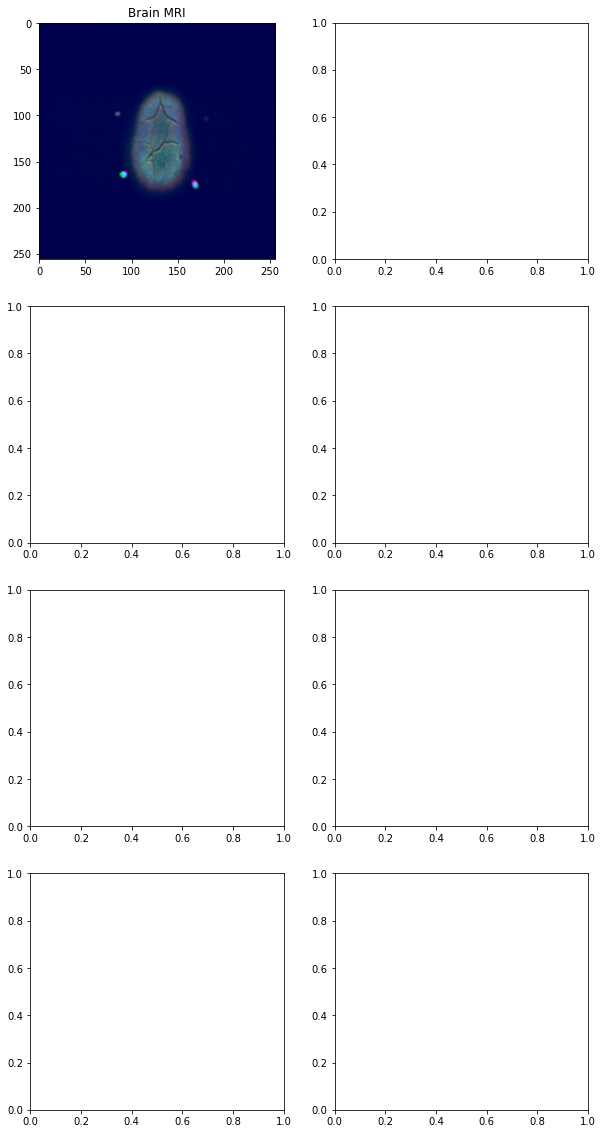

In [7]:
# Visualizing the images (MRI and Mask) in the dataset separately 
fig, axs = plt.subplots(4,2, figsize=(10,20))
count = 0
for x in range(4):
    i = random.randint(0, len(df)) # select a random index
    axs[count][0].title.set_text("Brain MRI") # set title
    axs[count][0].imshow(cv2.imread(df.image_path[i])) # Oshow MRI 
    axs[count][1].title.set_text("Mask - " + str(df['mask'][i])) # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread(df.mask_path[i])) # Show corresponding mask
    count += 1

fig.tight_layout()

In [ ]:
# Data distribution
ax = df['mask'].value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by mask: 0 or 1",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df['mask'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

In [ ]:
# Distribution of positive/negative diagnosis between each patient

# Data
patients_by_diagnosis = df.groupby(['patient', 'mask'])['mask'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)



In [ ]:
# Samples of images having positive mask

# Data
sample_df = df[df["mask"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (512, 512))
    mask = cv2.resize(cv2.imread(data[2]), (512, 512))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()


In [10]:
title = "Predictions of UNet with ResNeXt50 backbone"
base_name = "_".join(title.lower().split())
print(base_name)
base_len = len(base_name)
print(base_len)
end_len = len(".png")
fp_in = f"{base_name}*.png"
print(fp_in)
fp_out = f"{base_name}.gif"
print(fp_out)

predictions_of_unet_with_resnext50_backbone
43
predictions_of_unet_with_resnext50_backbone*.png
predictions_of_unet_with_resnext50_backbone.gif


In [19]:
from os.path import join
folder_path = "./output/gif_images/"
base_name = "_".join(title.lower().split())
file_path = join(folder_path,base_name)
print('file_path: '+ file_path)

base_len = len(file_path)
print('base_len: '+ str(base_len))


file_path: ./output/gif_images/predictions_of_unet_with_resnext50_backbone
base_len: 63


In [ ]:
def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name)
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f)
                  for f in sorted(glob.glob(fp_in),
                                  key=lambda x: int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)

    return fp_out